In [389]:
%load_ext autoreload

%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [390]:
import problem
import jax.numpy as jnp
import jax.scipy as jsp
import jax
import matplotlib.pyplot as plt
import yaml



#from problem import *

In [391]:
with open('config_basic.yml', 'r') as file:
        c = yaml.safe_load(file)

# Create spatial discretisation 
lat_first = c['spatial_discretisation']['lat_first']
lat_final = c['spatial_discretisation']['lat_final']
lat_n     = c['spatial_discretisation']['lat_n']
lng_first = c['spatial_discretisation']['lng_first']
lng_final = c['spatial_discretisation']['lng_final']
lng_n     = c['spatial_discretisation']['lng_n']

lat,lng = jnp.mgrid[lat_first:lat_final:lat_n*1j,
                    lng_first:lng_final:lng_n*1j]

# Code for pretty visualisations

In [635]:
def plot_vector_field(v, scale=1):
    plt.figure()
    quiv = plt.quiver(lng, -lat, v[1], -v[0], -state, scale=scale)
    print(quiv.scale)
    quiv.scale = scale*quiv.scale
    plt.xticks([])
    plt.yticks([])
    plt.gca().set_aspect('equal')
#print(state.flatten().shape)
#plot_vector_field(v_f)

In [393]:
def plot_colormap(x, show_solid=True):
    fig = plt.figure()
    image_ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
    bar_ax = fig.add_axes([0.92, 0.2, 0.04, 0.6])

    x += 0 if not show_solid else 0*1/state

    im = image_ax.imshow(x)
    image_ax.set_xticks([])
    image_ax.set_yticks([])

    fig.colorbar(im, cax=bar_ax)
    plt.show()

#plot_colormap(v[1])

# Test boundary aware functional equations

In [394]:
DTHETA, DLAMBDA = 1,1

class BoundaryAware():

    def __init__(self, state, neighbours, very_solid):
        self.state = state
        self.nbs = neighbours
        self.very_solid = very_solid
    
    def laplacian(self,y):
        return self.laplacian_divgrad(y)

    def laplacian_divgrad(self, y):
        
        return self.divergence(self.gradient(y)) +  y*(-1+self.state)
        
    def laplacian_rolls(self, y):
        yb = y*self.state

        y_i_next = jnp.roll(yb, shift=1, axis=-2)
        y_i_prev = jnp.roll(yb, shift=-1,axis=-2)
        y_j_next = jnp.roll(yb, shift=1 ,axis=-1)
        y_j_prev = jnp.roll(yb, shift=-1,axis=-1)
        return  y*(1-self.state) + self.state*(y_j_next #
                                            + y_i_next
                                            - self.nbs * yb 
                                            + y_j_prev 
                                            + y_i_prev) / (DTHETA*DLAMBDA)
    
    def laplacian_ps(self, y):
        return self.ptheta(self.ptheta(y)) + self.plambda(self.plambda(y))


    def ptheta(self, y):
        y_i_next = jnp.roll(y,          shift=1, axis=-2)
        y_i_prev = jnp.roll(y,          shift=-1,axis=-2)

        f_i_next = jnp.roll(self.state, shift=1, axis=-2)
        f_i_prev = jnp.roll(self.state, shift=-1,axis=-2)

        return self.state * ( # there is only a valid derivative in fluid cells
                 f_i_next * f_i_prev     * (y_i_next - y_i_prev) / 2  # case where both neighbours are fluid
               + f_i_next * (1-f_i_prev) * (y_i_next - y)             # case where only the next neighbour is fluid
               + (1-f_i_next) * f_i_prev * (y - y_i_prev)             # case where only the previous neighbour is fluid
            )/DTHETA                                        # when neither neighbour is fluid, the previous two cases cancel out
             
    def plambda(self, y): 
        y_j_next = jnp.roll(y,          shift= 1,axis=-1)
        y_j_prev = jnp.roll(y,          shift=-1,axis=-1)

        f_j_next = jnp.roll(self.state, shift= 1,axis=-1)
        f_j_prev = jnp.roll(self.state, shift=-1,axis=-1)

        return self.state * (  # there is only a valid derivative in fluid cells
                 f_j_next * f_j_prev     * (y_j_next - y_j_prev) / 2  # case where both neighbours are fluid
               + f_j_next * (1-f_j_prev) * (y_j_next - y)             # case where only the next neighbour is fluid
               + (1-f_j_next) * f_j_prev * (y - y_j_prev)             # case where only the previous neighbour is fluid
            )/DTHETA                                        # when neither neighbour is fluid, the previous two cases cancel out

    def gradient(self, y):
        return jnp.array( (self.ptheta(y), self.plambda(y)))
    
    def divergence(self, y):
        return self.divergence_roll(y)

    def divergence_ps(self, y):
        return self.ptheta(y[0]) + self.plambda(y[1])

    def divergence_roll(self, y):
        y_i_next = jnp.roll(y[0], shift=1, axis=-2)
        y_i_prev = jnp.roll(y[0], shift=-1,axis=-2)
        y_j_next = jnp.roll(y[1], shift=1 ,axis=-1)
        y_j_prev = jnp.roll(y[1], shift=-1,axis=-1)
        return (y_i_next - y_i_prev + y_j_next - y_j_prev) #*self.state

In [504]:
def neighbours(state):
    s_i_next = jnp.roll(state, shift=1, axis=-2)
    s_i_prev = jnp.roll(state, shift=-1,axis=-2)
    s_j_next = jnp.roll(state, shift=1 ,axis=-1)
    s_j_prev = jnp.roll(state, shift=-1,axis=-1)

    return s_i_next + s_i_prev + s_j_next + s_j_prev

5


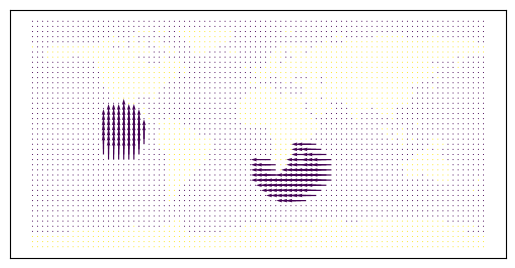

In [691]:
v = jnp.zeros((2, lat.shape[0], lat.shape[1]))
v = v.at[0].set( -1 * ((jnp.square(lat-0.1) + jnp.square(lng+1.9))<.1) )
v = v.at[1].set( -1 * ((jnp.square(lat-0.5) + jnp.square(lng-.6))<.2) )


state = 1 - 1 * ((jnp.square(lat) + jnp.square(lng+1.35))<0.7)
state = state_world.astype(float)
state_neighbours = neighbours(state)*state
fluid_neighbours = state_neighbours
very_solid = neighbours(1-state)==4


v *= state

plot_vector_field(v, scale=5)

ba = BoundaryAware(state, state_neighbours, very_solid)

/tmp/ipykernel_607/460508397.py:6: RuntimeWarning: invalid value encountered in divide
  x += 0 if not show_solid else 0*1/state


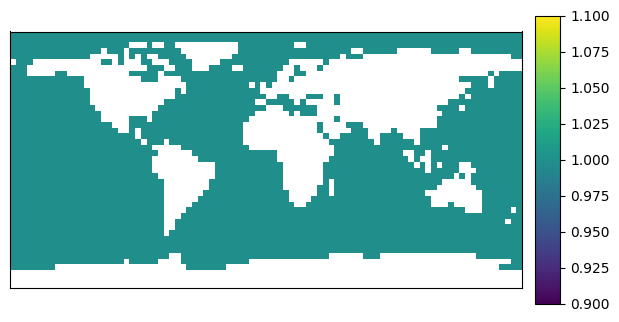

In [512]:
#plt.imshow(state)
plot_colormap(state, show_solid=True)

Text(0.5, 1.0, ' horizontal derivative of horizontal velocity')

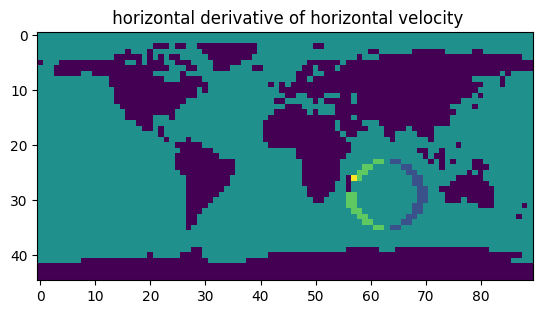

In [593]:
plt.imshow(ba.plambda(v[1])+ state)
plt.title(' horizontal derivative of horizontal velocity')

Text(0.5, 1.0, 'laplacian of horizontal velocity')

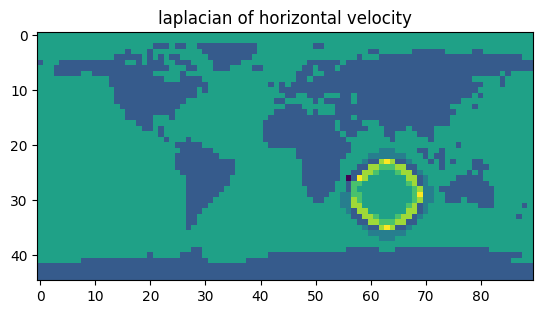

In [594]:
plt.imshow(ba.laplacian(v[1]) + state)
plt.title('laplacian of horizontal velocity')

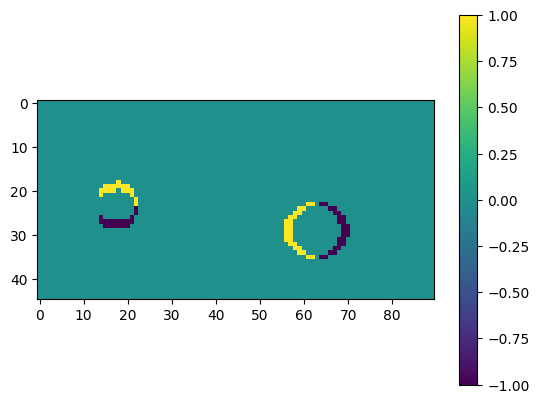

In [595]:
plt.imshow(ba.divergence(v) )
plt.colorbar()

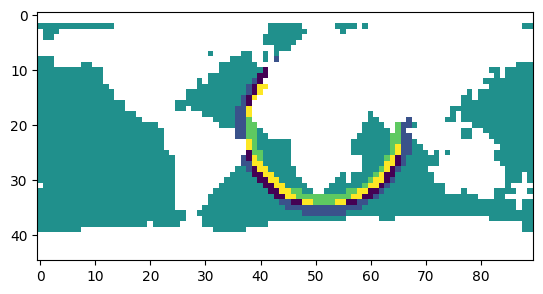

In [516]:
plt.imshow( ba.divergence( ba.gradient(v[1])))

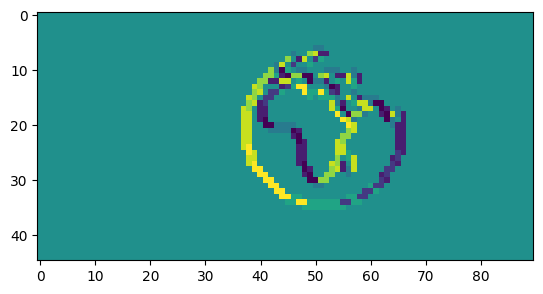

In [517]:
plt.imshow(ba.divergence(v))

# eval  stuff

In [403]:
def my_laplacian(x):
    x =x.reshape((lat_n,lng_n))
    thing = ba.laplacian(x)
    return thing.flatten()

def flatten_linop(f, shape=(lat_n, lng_n)):
    return lambda x: (f(x.reshape(shape))).flatten()

lap_test = ba.laplacian
my_laplacian = flatten_linop(lap_test)


##compute the jacobi matrix
jacobian = jax.jacobian(my_laplacian)

In [404]:
flat_laplacian = lambda x: (ba.laplacian(x.reshape((lat_n, lng_n)))).flatten() 
jacobian_matrix = jax.jacobian(flat_laplacian)(jnp.zeros( lat_n*lng_n ))
print( (jacobian_matrix == jacobian_matrix.T).all() )

False


In [405]:
resulting_matrix = jacobian(jnp.ones(lat_n*lng_n))
resulting_matrix2 = jacobian(jnp.zeros(lat_n*lng_n))
is_linear_maybe = bool( ((resulting_matrix - resulting_matrix2) == 0).all() )
print('Laplacian is linear (probably): {}'.format(is_linear_maybe))

Laplacian is linear (probably): True


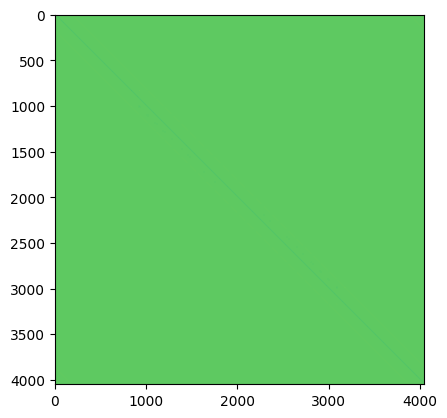

In [406]:
plt.imshow(resulting_matrix)

In [407]:
is_symmetrical = bool( jnp.isclose(resulting_matrix ,resulting_matrix.T).all() )
print('Laplacian is symmetrical: {}'.format(is_symmetrical))

#print(jnp.where(resulting_matrix -resulting_matrix.T == 1))

Laplacian is symmetrical: False


In [408]:
evals, evecs = jnp.linalg.eigh((resulting_matrix + resulting_matrix.T)/2)


In [409]:
(evecs * evecs.T).std()

Array(0.00024819, dtype=float32)

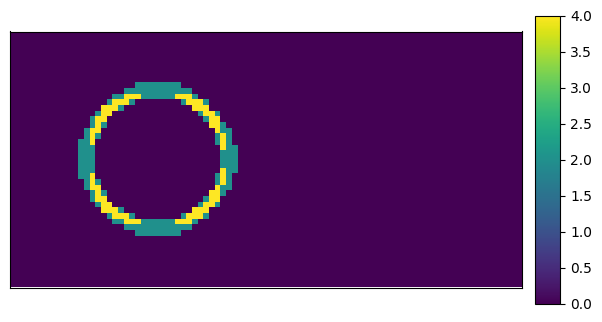

In [410]:
plot_colormap( jnp.sum(jnp.abs(resulting_matrix-resulting_matrix.T),axis=1).reshape(lat_n,lng_n), show_solid=False)


In [411]:
evecs.shape

(4050, 4050)

In [412]:
(evecs @ jnp.diag(evals) @ evecs.T - resulting_matrix).std()

Array(0.00293194, dtype=float32)

In [413]:
(evecs @ jnp.diag(evals) @ evecs.T - resulting_matrix).mean()

Array(-4.2518492e-11, dtype=float32)

In [414]:
(evecs @ jnp.diag( evals) @ evecs.T)

Array([[-2.00000000e+00,  9.31322575e-08,  4.99999911e-01, ...,
         1.30385160e-08, -3.35276127e-08, -1.17346644e-07],
       [ 9.31322575e-08, -1.99999869e+00, -3.49245965e-07, ...,
        -5.30853868e-08,  9.31322575e-10, -1.37835741e-07],
       [ 4.99999940e-01, -3.47383320e-07, -1.99999952e+00, ...,
        -1.76019967e-07,  1.11758709e-07,  1.17346644e-07],
       ...,
       [ 1.11758709e-08, -5.30853868e-08, -1.79745257e-07, ...,
        -2.00000048e+00,  2.11410224e-07,  5.00000656e-01],
       [-2.98023224e-08,  2.79396772e-09,  1.11758709e-07, ...,
         2.11410224e-07, -2.00000048e+00,  1.61118805e-07],
       [-1.13621354e-07, -1.56462193e-07,  1.24797225e-07, ...,
         5.00000596e-01,  1.56462193e-07, -2.00000048e+00]],      dtype=float32)

In [415]:
((resulting_matrix @ evecs ) / evals - evecs).std()

Array(0.21483481, dtype=float32)

In [416]:
print(0 in evals)

False


In [417]:
print(jnp.amin(jnp.abs(evals)))

0.0007045455


In [418]:
print(jnp.amin(-evals))

-0.19628026


Text(0, 0.5, 'Frequency')

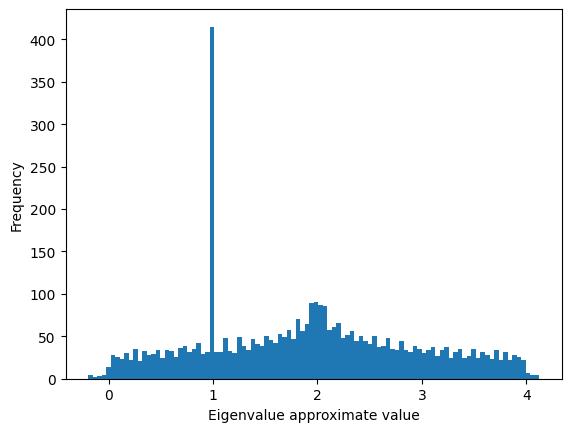

In [419]:
plt.hist(-evals, bins=100)
plt.xlabel('Eigenvalue approximate value')
plt.ylabel('Frequency')

In [420]:
evecs

Array([[ 7.32697721e-04, -3.76398326e-04,  2.12267241e-05, ...,
         1.67426959e-04,  1.18226626e-06, -1.29331522e-06],
       [-1.24945072e-05,  3.90958798e-04,  1.33921058e-05, ...,
         2.58537388e-04, -4.58627255e-07, -1.43246348e-06],
       [-1.08058471e-03,  5.56781422e-04, -2.62732501e-05, ...,
         2.62497517e-04,  1.94412996e-06, -2.29026705e-06],
       ...,
       [ 1.01454107e-05,  1.70695304e-04, -4.80409017e-06, ...,
         1.00155128e-04,  1.43629265e-07, -4.88224998e-07],
       [ 4.88624035e-04,  2.49658420e-04,  1.64237572e-05, ...,
         1.04544924e-04, -6.14073258e-07, -7.73478860e-07],
       [-1.18414582e-05, -2.60339089e-04,  8.09602170e-06, ...,
         1.62184748e-04,  2.75549525e-07, -8.56194220e-07]],      dtype=float32)

In [421]:
evals[714]

Array(-2.9604447, dtype=float32)

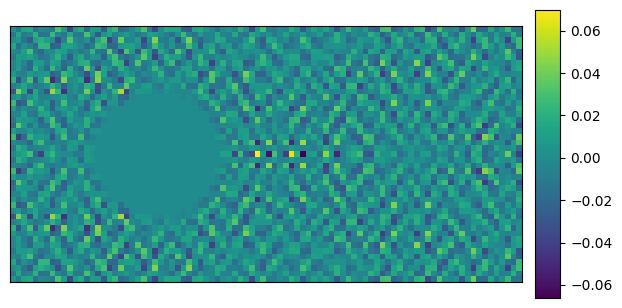

-3.3160405


In [422]:
i = 450
plot_colormap( evecs[:,i].reshape(lat_n,lng_n), show_solid=False )
print(evals[i])

In [462]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

def plot_2d_slice(x=0, y=0):
    # Adjust the slice selection as needed for your specific case
    # This example selects a 2D slice by fixing two dimensions and varying the other two
    plot_colormap( evecs[:,x + y].reshape(lat_n,lng_n), show_solid=False )
    print(x+y, evals[x+y])


# `interact` function call to create two sliders
interact(plot_2d_slice,
x=IntSlider(min=0, max=lat_n*lng_n-1, step=1, value=0, description='X Dimension'),
y=IntSlider(min=0, max=lat_n-1, step=1, value=0, description='Y Dimension'))


interactive(children=(IntSlider(value=0, description='X Dimension', max=4049), IntSlider(value=0, description=…

<function __main__.plot_2d_slice(x=0, y=0)>

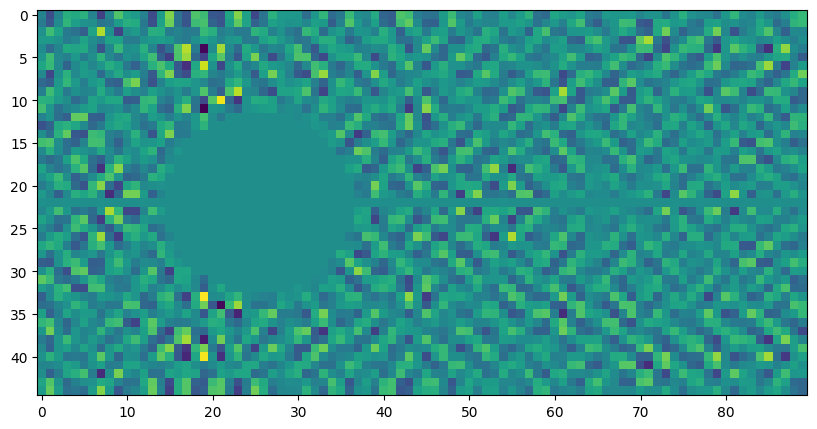

In [424]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.imshow( evecs[:,400].reshape(lat_n,lng_n) )

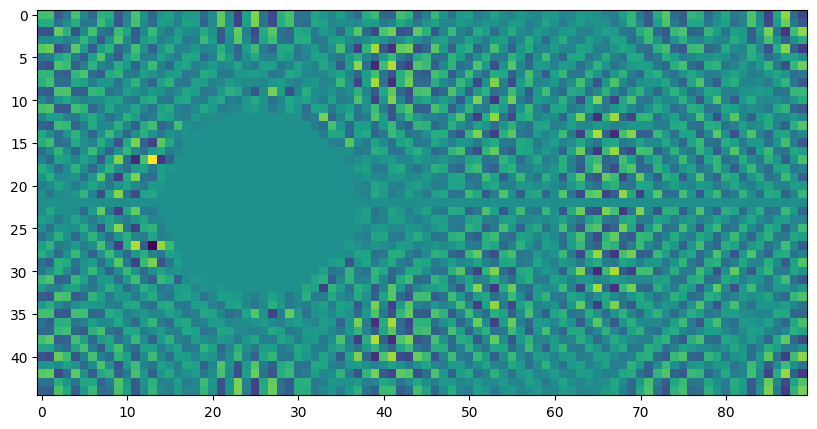

In [425]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.imshow( evecs[:,100].reshape(lat_n,lng_n) )

In [426]:
jnp.sum(jnp.log( jnp.abs(evals)) )

Array(1653.5005, dtype=float32)

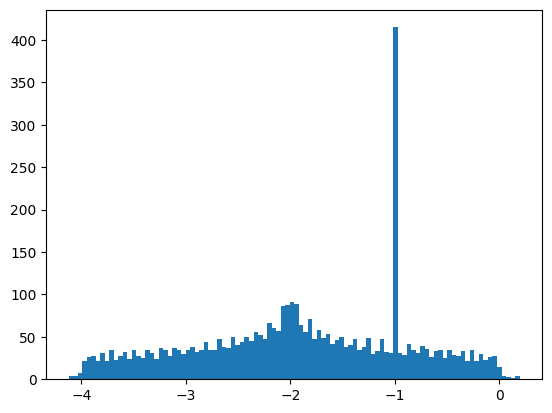

In [427]:
O = plt.hist(evals, bins = 100)

In [428]:
inverse_matrix = jsp.linalg.inv(resulting_matrix)
inverse_matrix @ resulting_matrix

Array([[ 1.0001831e+00,  1.2207031e-04, -2.8991699e-04, ...,
        -3.7841797e-03, -4.8828125e-04, -2.1057129e-03],
       [ 1.8310547e-04,  1.0007324e+00, -9.1552734e-05, ...,
        -3.2958984e-03, -4.2724609e-04, -2.1362305e-03],
       [ 1.8310547e-04,  3.6621094e-04,  9.9981689e-01, ...,
        -3.6621094e-03, -4.2724609e-04, -2.3498535e-03],
       ...,
       [ 1.2207031e-04,  6.1035156e-04, -9.1552734e-05, ...,
         9.9658203e-01, -5.4931641e-04, -2.3803711e-03],
       [ 1.2207031e-04,  2.4414062e-04, -1.2207031e-04, ...,
        -3.4179688e-03,  9.9940491e-01, -2.3193359e-03],
       [ 6.1035156e-05,  3.6621094e-04, -6.1035156e-05, ...,
        -3.4179688e-03, -5.9509277e-04,  9.9755859e-01]], dtype=float32)

In [429]:
unique_values, counts = jnp.unique(jnp.array(resulting_matrix, dtype=jnp.int32), return_counts=True)

print("Unique values and their counts:")
for value, count in zip(unique_values, counts):
    print(f"{value}: {count}")

Unique values and their counts:
-3: 6
-2: 3552
-1: 586
0: 16398168
1: 188


# test divfree projection with boundary condidtions

In [659]:
# Initial conditions

v = jnp.zeros((2, lat.shape[0], lat.shape[1]))
v = v.at[0].set( 0.2 * ((jnp.square(lat+0.1) + jnp.square(lng-0.5))<1) )
v = v.at[1].set( -1 * ((jnp.square(lat+0.1) + jnp.square(lng-0.5))<1) )

def symm_lap(x):
    return ( ((resulting_matrix+resulting_matrix2)/2) @ x.flatten()).reshape(lat_n,lng_n)

state = 1 - 1 * ((jnp.square(lat) + jnp.square(lng+1.35))<0.7)
#state = state_world
#state = 1 - 1 * ((jnp.square(lat+0.5) + jnp.square(lng+2))<0.7)
v*=state

fluid_neighbours = neighbours(state)

ba = BoundaryAware(state, fluid_neighbours, very_solid)


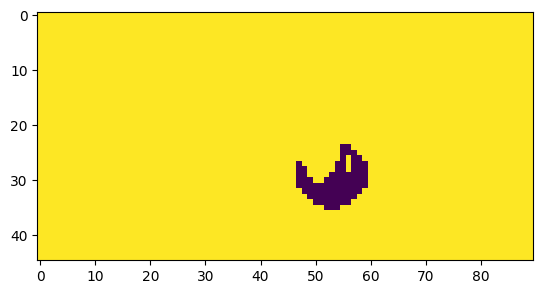

In [692]:
plt.imshow(v[1])

KeyboardInterrupt: 

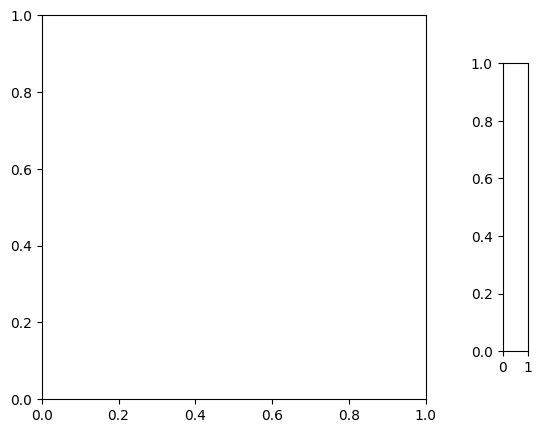

In [699]:
def blur(arr):
    return (jnp.roll(arr*state,  1, axis=-2)
          + jnp.roll(arr*state, -1, axis=-2)
          + jnp.roll(arr*state,  1, axis=-1)
          + jnp.roll(arr*state, -1, axis=-1)
          + arr) / (fluid_neighbours + 1 ) *state

v = blur(v)
#v = v.at[:,state==0].set(0)
plot_colormap(v[1], show_solid=False)
plt.title('blurred horizontal v')

In [618]:
#from problem import *



def project_divergencefree2(v, lap=ba.laplacian, q_guess=None, state=None, fluid_neighbours=None, cg_runs = 2):

    ba = BoundaryAware(state, fluid_neighbours, very_solid)

    iters = (100, 50, 10)
    blurs = (True, True, False)

    

    v_f = v
    # Repeats as conjugate gradient descent does not necessarily converge to correct solution after 1 run
    for i in range(cg_runs):
        # q is the exact "pressure" needed to maintain densities
        qi, _ = jsp.sparse.linalg.cg(
            lap,
            -ba.divergence(v_f), 
            maxiter= iters[i])
        #q_total += q
        v_f += ba.gradient(qi)
        if blurs[i]:
            v_f = blur(v_f)

    return v_f, q
    #return  q
    #return v + gradient(q)


Text(0.5, 1.0, 'divergence of v')

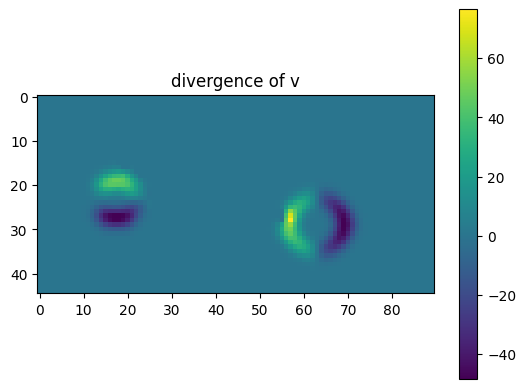

In [602]:
plt.imshow(ba.divergence(v))
plt.colorbar()
plt.title('divergence of v')

In [603]:
print(jnp.sum(ba.divergence(v)))
print(jnp.sum(problem.divergence(v)))

0.0
0.0


-125.69871 66.48123


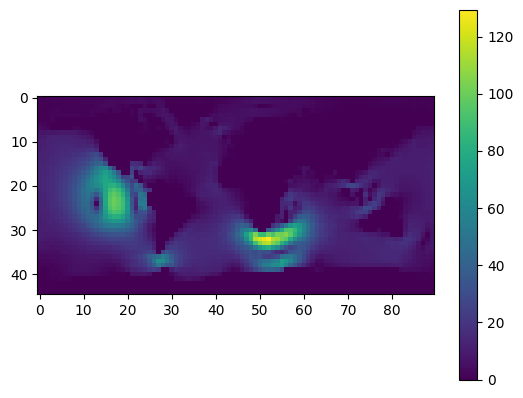

In [619]:
def normv(v): return jnp.sqrt(jnp.square(v[0]) + jnp.square(v[1]))


v_f, q1 = project_divergencefree2(v, lap=ba.laplacian, state=state, fluid_neighbours = fluid_neighbours, cg_runs = 3)
print(jnp.amin(v_f), jnp.amax(v_f))

plt.imshow((normv(v_f)))
plt.colorbar()

40


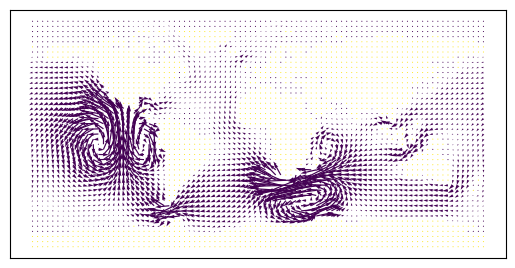

In [649]:
plot_vector_field((v_f), scale=40)

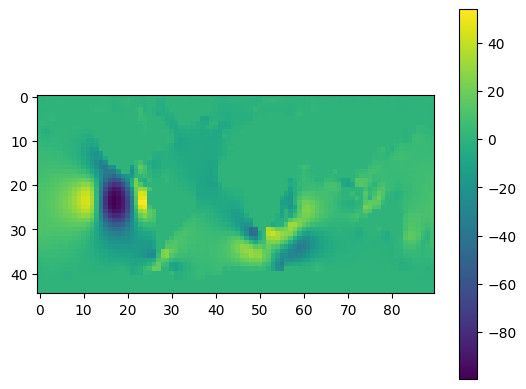

In [621]:
plt.imshow(v_f[0])
plt.colorbar()

/tmp/ipykernel_607/1045689357.py:1: RuntimeWarning: invalid value encountered in divide
  plt.imshow(v_f[1] + 0*1/(state))


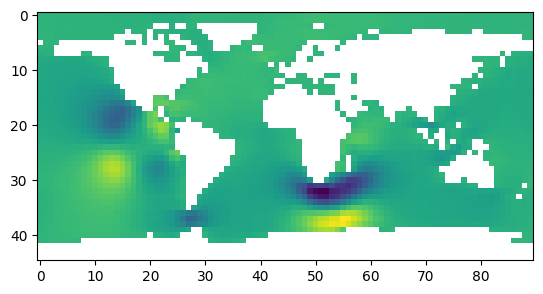

In [622]:
plt.imshow(v_f[1] + 0*1/(state))

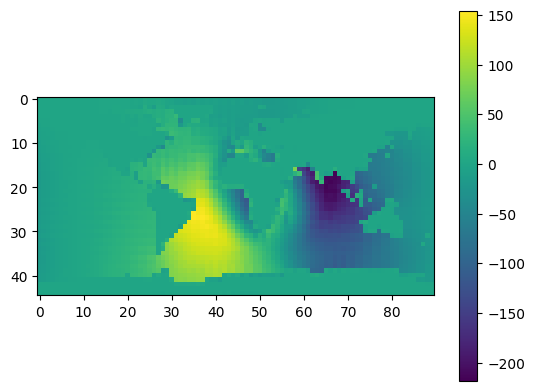

In [623]:
plt.imshow(q1)
plt.colorbar()

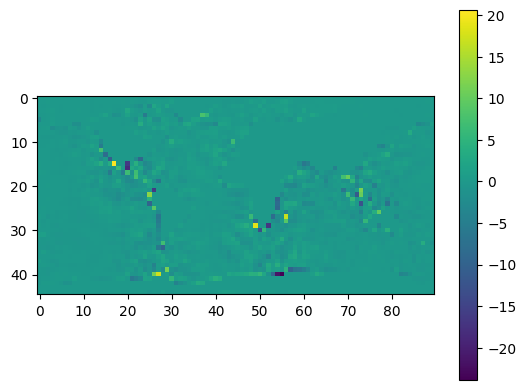

In [624]:
plt.imshow(ba.divergence(v_f))
plt.colorbar()

In [440]:
print((state*ba.divergence(v_f)).mean(), (state*ba.divergence(v_f)).std())

-0.0002985563 0.005454538


In [441]:
ba = BoundaryAware(state, fluid_neighbours, very_solid)

q, _ = jsp.sparse.linalg.cg(
    ba.laplacian,
    -ba.divergence(v), 
    maxiter=500)

v1 = blur(v + state*ba.gradient(q))

q1, _ = jsp.sparse.linalg.cg(
    ba.laplacian,
    -ba.divergence(v1), 
    maxiter= 100)
#q_total += q

v2 = blur(v1 + state*ba.gradient(q1))

q2, _ = jsp.sparse.linalg.cg(
    ba.laplacian,
    -ba.divergence(v2), 
    maxiter= 10)
#q_total += q

v3 = blur(v2 + state*ba.gradient(q2))

In [442]:
def ptheta(y):
    y_i_next = jnp.roll(y, shift=1, axis=-2)
    y_i_prev = jnp.roll(y, shift=-1,axis=-2)
    return (y_i_next - y_i_prev) / (2*DTHETA)
    
def plambda(y):
    y_j_next = jnp.roll(y, shift=1, axis=-1)
    y_j_prev = jnp.roll(y, shift=-1,axis=-1)
    return (y_j_next - y_j_prev) / (2*DLAMBDA)  
    
def gradient(y):
    return jnp.array( (ptheta(y), plambda(y))) 

In [523]:
ba = BoundaryAware(state, fluid_neighbours, very_solid)

q, _ = jsp.sparse.linalg.cg(
    ba.laplacian,
    -ba.divergence(v), 
    maxiter= 100)

v1 = blur(v + state*ba.gradient(q))

q1, _ = jsp.sparse.linalg.cg(
    ba.laplacian,
    -ba.divergence(v1), 
    maxiter= 50)
#q_total += q

v2 = blur(v1 + state*ba.gradient(q1))

q2, _ = jsp.sparse.linalg.cg(
    ba.laplacian,
    -ba.divergence(v2), 
    maxiter= 10)
#q_total += q

v3 = (v2 + state*ba.gradient(q2))

In [524]:
plot_vector_field(v)

TypeError: The numpy boolean negative, the `-` operator, is not supported, use the `~` operator or the logical_not function instead.

<Figure size 640x480 with 0 Axes>

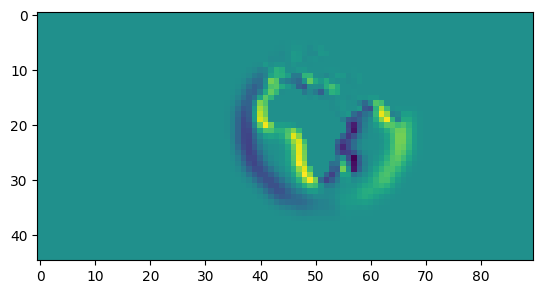

In [525]:
plt.imshow(-ba.divergence(v))


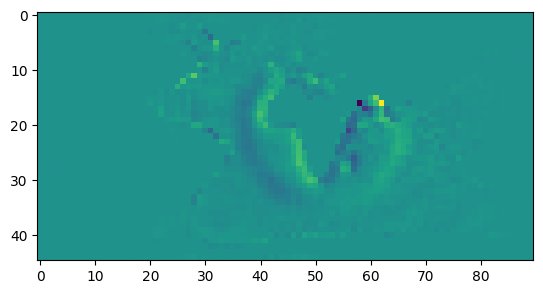

In [526]:
plt.imshow(ba.laplacian(q))  #looks very different without state


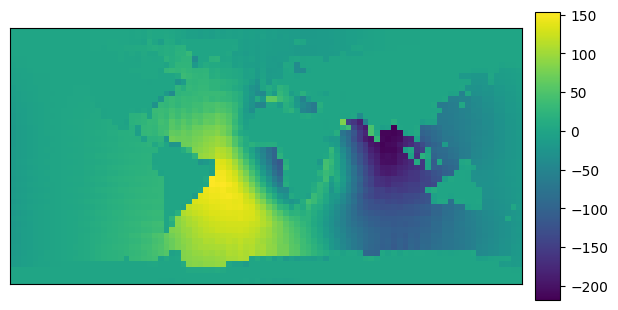

In [527]:
plot_colormap(q, show_solid=False)

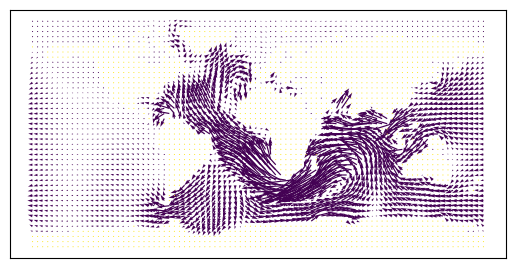

In [541]:
plot_vector_field(v1)

/tmp/ipykernel_607/460508397.py:6: RuntimeWarning: invalid value encountered in divide
  x += 0 if not show_solid else 0*1/state


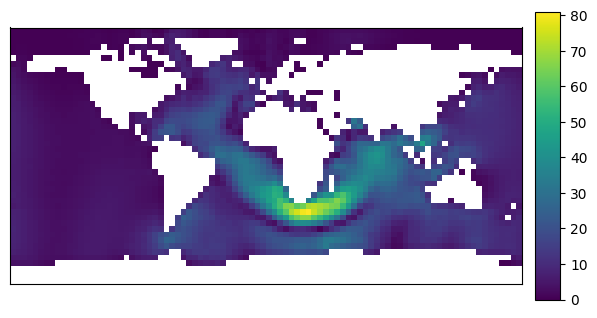

In [529]:
plot_colormap(normv(v1))

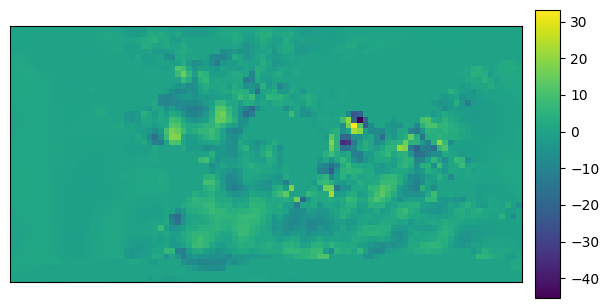

In [542]:
plot_colormap(-ba.divergence(v1), show_solid=False)


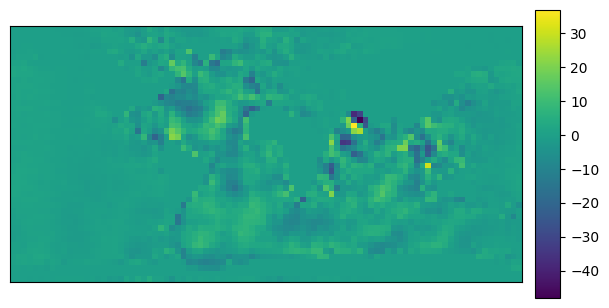

In [543]:
plot_colormap(ba.laplacian(q1), show_solid=False)

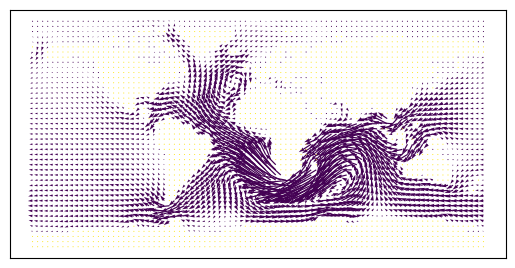

In [544]:
plot_vector_field(v2)

/tmp/ipykernel_607/460508397.py:6: RuntimeWarning: invalid value encountered in divide
  x += 0 if not show_solid else 0*1/state


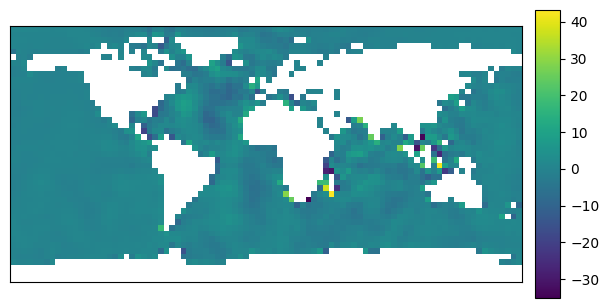

In [545]:
plot_colormap(-ba.divergence(v2))


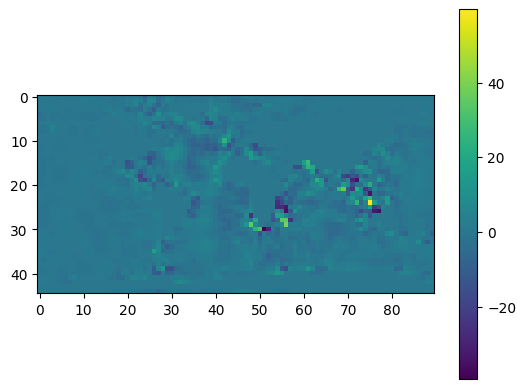

In [546]:
plt.imshow(ba.laplacian(q2))
plt.colorbar()

In [547]:
print( jnp.mean(jnp.abs(ba.laplacian(q2) + ba.divergence(v2))))

0.87596697


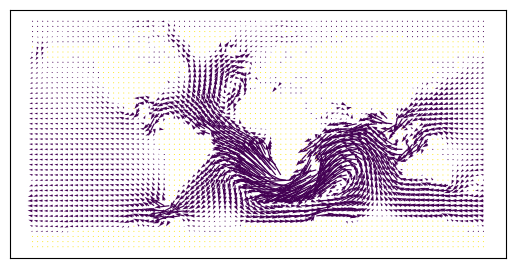

In [548]:
plot_vector_field(v3)

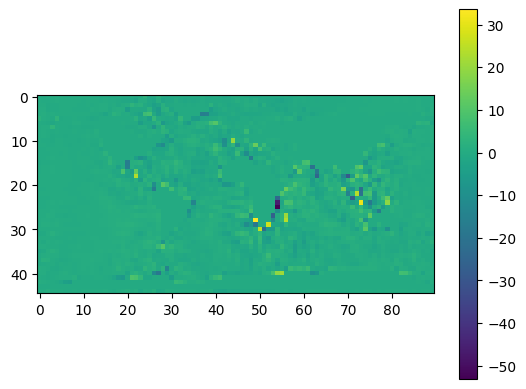

In [536]:
plt.imshow(-ba.divergence(v3))
plt.colorbar()

In [537]:
jnp.abs(ba.divergence(v3)*state).mean()

Array(0.59706515, dtype=float32)

# bathymetry

In [459]:
import numpy as np

In [460]:
# Assuming `data` is your N-dimensional numpy array
data = np.random.rand(10, 20, 30)  # Example: 3D array
print('data created')

def plot_slice(x=0):
    plt.imshow(data[:, :, x], interpolation='nearest')
    plt.show()

interact(plot_slice, x=IntSlider(min=0, max=data.shape[2]-1, step=1, value=0))

data created


interactive(children=(IntSlider(value=0, description='x', max=29), Output()), _dom_classes=('widget-interact',…

<function __main__.plot_slice(x=0)>

In [479]:
import cv2
import numpy as np
import os

def get_map_path(config):

    if config["map"]["mask_image_path_relative"]:
        print('opening path ', os.path.join( os.getcwd(), config["map"]["mask_image_path"] ))
        print(os.path.join( os.getcwd(), config["map"]["mask_image_path"] ))
        return os.path.join( os.getcwd(), config["map"]["mask_image_path"] )
    else:
        return config["map"]["mask_image_path"]


def load_np(config):

    image_np = cv2.imread(get_map_path(config)) 

    return image_np[:,:,::-1]



import matplotlib.pyplot as plt

config = {"map": {"mask_image_path_relative": True, 
                    "mask_image_path": "resources/map/gebco_08_rev_bath_3600x1800_color.jpg"}}

im = load_np(config).astype(int)

#plt.show()

opening path  /mnt/c/Users/spenc/OneDrive/Documents/GitHub/THCsim/resources/map/gebco_08_rev_bath_3600x1800_color.jpg
/mnt/c/Users/spenc/OneDrive/Documents/GitHub/THCsim/resources/map/gebco_08_rev_bath_3600x1800_color.jpg


(1800, 3600, 3)


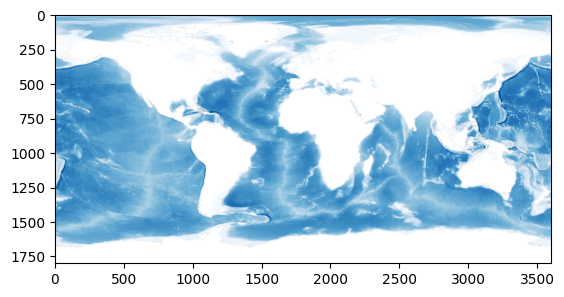

In [466]:
print(im.shape)

im3 = im[:,:,:] + (np.isclose(im[:,:,0],im[:,:,2], atol=4))[:,:,np.newaxis]*255

im3[im3>255]=255

plt.imshow(im3)

opening path  /mnt/c/Users/spenc/OneDrive/Documents/GitHub/THCsim/resources/map/gebco_08_rev_bath_3600x1800_color.jpg
/mnt/c/Users/spenc/OneDrive/Documents/GitHub/THCsim/resources/map/gebco_08_rev_bath_3600x1800_color.jpg


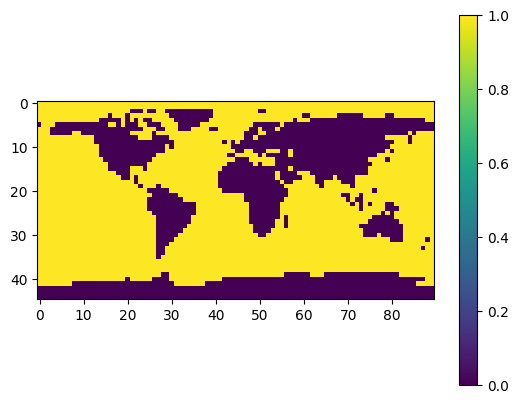

In [503]:

im = load_np(config)
small_im = cv2.resize(im, (lng_n, lat_n), interpolation=cv2.INTER_LINEAR)
state_world = small_im[:,:,2]>5


plt.imshow((small_im[:,:,2]>5))
plt.colorbar()